# GPU 실습
## GPU 사용 가능여부 확인

In [90]:
import torch
print("torch.cuda.is_availible(): ", torch.cuda.is_available())
print("torch.cuda.get_device_name(): ", torch.cuda.get_device_name())

torch.cuda.is_availible():  True
torch.cuda.get_device_name():  Tesla T4


## GPU와 CPU 성능 확인

> 1000 * 1000 matrix 연산

Ctrl + Enter를 눌러서 반복 실행해보세요

In [91]:
import torch
import time

if torch.cuda.is_available():
  
    x = torch.ones(1000, 1000).to(torch.device("cpu"))  # 1000x1000 배열에 1을 채우고 CPU 동작모드로 설정
    y = 2 * x + 3
    start_time = time.time()
  
    # Matrix multiplication (for benchmark purpose)
    results = torch.mm(x, y)
    time_cpu = time.time() - start_time

    # Do the same calculation but on the gpu
    # First move tensors to gpu
    # CUDA(Compute Unified Device Architecture) - NVDIA 에서 만든 GPU 에서 수행하는 병렬처리 알고리즘
    x = x.to("cuda")   # 1000 * 1000 메트릭스를 GPU 모드로 설정
    y = y.to("cuda")
    start_time = time.time()
    # Matrix multiplication (for benchmark purpose)
    results = torch.mm(x, y)
    time_gpu = time.time() - start_time
    if time_gpu == 0:
        time_gpu = 0.0000001
    print("Time on CPU: {:.7f}s \t Time on GPU: {:.7f}s".format(time_cpu, time_gpu))
    print("Speed up: Computation was {:.0f}X faster on GPU!".format(time_cpu / time_gpu))

else:
    print("You need to enable GPU accelaration in colab (runtime->change runtime type)")

Time on CPU: 0.0282638s 	 Time on GPU: 0.0002308s
Speed up: Computation was 122X faster on GPU!


# Neural Network 실습
## 임의좌표 생성

### 데이터 생성 및 labeling 코드 취합

In [92]:
import numpy as np
import pandas as pd
from random import random

def generate(func, num=100, max=10, val_ratio=0.25):
  X = np.random.rand(num,2)
  X *= max

  data_list = []
  for x in X:
    label = 0 if x[1] > func(x[0]) else 1
    data = {
        "dataset": "train" if random() > val_ratio else "val",
        "x0": x[0],
        "x1": x[1],
        "label": label,
        "class0": 1 if label == 0 else 0,
        "class1": 1 if label == 1 else 0,
    }
    data_list.append(data)

  df = pd.DataFrame(data_list)
  df = df.sort_values(by="dataset")

  return df

## 단계1. 데이터 생성

   dataset        x0        x1  label  class0  class1
0    train  9.817776  5.880785      1       0       1
71   train  6.656920  5.546359      1       0       1
70   train  4.915033  1.099654      1       0       1
65   train  6.264199  6.215659      0       1       0
63   train  1.542050  8.959660      0       1       0
..     ...       ...       ...    ...     ...     ...
66     val  0.947641  3.563557      1       0       1
67     val  5.650820  6.423189      0       1       0
68     val  0.752641  4.441816      1       0       1
73     val  7.225486  1.288476      1       0       1
69     val  1.865421  1.914840      1       0       1

[100 rows x 6 columns]
Dataset/Label value counts
 dataset  label
train    1        45
         0        24
val      1        23
         0         8
dtype: int64


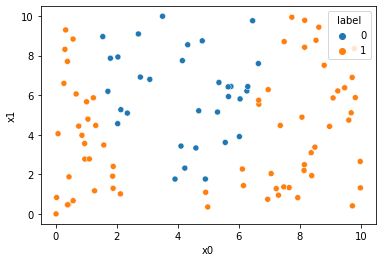

In [93]:
import math
import seaborn as sb

def func1(x):
  return 0.03 * math.pow(x-4,3) + 3

def func2(x):
  return 0.7 * math.pow(x-4,2) + 1

# df = generate(func1, 100, 10)
df = generate(func2, 100, 10)
print(df)
print("Dataset/Label value counts\n", df[["dataset", "label"]].value_counts())
sb.scatterplot(data=df, x="x0", y="x1", hue="label")


## 단계2. pytorch 및 GPU 사용 준비

In [94]:
import torch
from torch import optim
torch.__version__


'1.12.1+cu113'

In [95]:

print("torch.cuda.is_availible(): ", torch.cuda.is_available())
print("torch.cuda.get_device_name(): ", torch.cuda.get_device_name())

torch.cuda.is_availible():  True
torch.cuda.get_device_name():  Tesla T4


In [96]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 단계3. Nueral Network 구성
총 5개 layer

|Layer|Input|Output|Remarks|
|---|---|---|:---:|
|1|**2(feature)**|10|ReLU|
|2|10|20|ReLU|
|3|20|20|ReLU|
|4|20|10|ReLU|
|5|10|**2(label)**|-|

In [97]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class NN(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(NN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Linear(in_features, 10),      # layer1 - input
            nn.ReLU(),         
            
            nn.Linear(10, 20),            # layer2 - hidden
            nn.ReLU(),
            
            nn.Linear(20, 20),            # layer3 - hidden
            nn.ReLU(),
            
            nn.Linear(20, 10),            # layer4 - hidden
            nn.ReLU(),

            nn.Linear(10, out_features),     # layer5 - out
        )
        
    def forward(self, x):

        out = self.nn(x) 
        out = F.softmax(out, dim=1)
        
        return out

    def predict(self, x: pd.DataFrame) -> np.ndarray:

      x =  torch.from_numpy(x).to(device, dtype=torch.float32)
      out = self.forward(x)
      out = out.cpu().detach().numpy()
      labels = []
      for o in out:
          labels.append(
              0 if o[0] > o[1] else 1
          )
      return np.array(labels)

In [98]:
model = NN(in_features=2, out_features=2)
model.to(device)
print(model)

NN(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [99]:
#!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 20]             220
              ReLU-4                   [-1, 20]               0
            Linear-5                   [-1, 20]             420
              ReLU-6                   [-1, 20]               0
            Linear-7                   [-1, 10]             210
              ReLU-8                   [-1, 10]               0
            Linear-9                    [-1, 2]              22
Total params: 902
Trainable params: 902
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

## 단계4. Nueral Network 학습

In [100]:
from torch.autograd import Variable
import time
from tqdm import tqdm

def split(df):

  return {
    "train": {
      "features": df[df["dataset"] == "train"][["x0", "x1"]].to_numpy(),
      "labels": df[df["dataset"] == "train"][["class0", "class1"]].to_numpy()
    },
    "val": {
      "features":  df[df["dataset"] == "val"][["x0", "x1"]].to_numpy(),
      "labels": df[df["dataset"] == "val"][["class0", "class1"]].to_numpy()
    }
  }

def train(model, df, num_epochs, loss_func, optimizer):

    loss_list = []  # 중간 결과값을 보여주기 위해

    dataset = split(df)
    # total_step = len(df[df['dataset']=='train'])      
    
    pbar =  tqdm(range(num_epochs))  # progress를 보여주기 위함
    for epoch in pbar:
        loss_dict = {     # 중간 결과값을 보여주기 위해
            'train': 0.,
            'val': 0.
        }        
        start_time = time.time()
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # backprobagation을 위한 변수들을 활성화
            else:
                model.eval()    # backpropagation을 위한 변수들을 비활성화

            # for i in range(len(features)):

            features = torch.from_numpy(dataset[phase]["features"]).to(device, dtype=torch.float32)
            labels = torch.from_numpy(dataset[phase]["labels"]).to(device, dtype=torch.float32)

            # iteration
            loss = 0    # iteration loss
            for idx in range(len(features)):
                feature = features[idx]        
                feature = feature.view(1, -1)   # NN 모델에 입력하기위한 형태로 변환
                output = model(feature)         # NN 모델에 입력
                loss =+ loss_func(output, labels.unsqueeze(1)[idx])  # NN모델이 입력한 값과 실제 값의 오차 게산

                loss_dict[phase] += loss.item()
                
                if phase == 'train':
                    optimizer.zero_grad()     # 이전 오차계산값 지우기 (clear gradients for this training step)               
                    loss.backward()           # 오차계산 (backpropagation, compute gradients)       
                    optimizer.step()          # 오차를 계산한 각 neural(layer) 들의 w값 업데이트 (apply gradients)                 

                # print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.6f}") 
                        
        train_loss = loss_dict["train"] / len(dataset["train"]["features"]) 
        val_loss = loss_dict["val"] / len(dataset["val"]["features"]) 
        # test_loss가 가장 작을때의 weight 를 저장
        if epoch == 0:
            min_loss = val_loss
            best_model = model.state_dict()
        elif val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
        
        # 학습 중간과정 출력을 보여주기 위한 코드        
        loss_list.extend([
            {"epoch": epoch, "loss": train_loss, "phase":"train"},
            {"epoch": epoch, "loss": val_loss, "phase":"val"},
        ])

        duration = time.time() - start_time # 동작시간 계산
        pbar.set_description(
              f"train_loss:{train_loss:.5f}, "
              f"val_loss:{val_loss:.5f} "
              f"duration: {duration:.1f}s"
        )

    # test_loss가 가장 작을때의 weight 로 복원
    model.load_state_dict(best_model)

    df = pd.DataFrame(loss_list)
        
    return model, df
        

In [101]:
model = NN(2, 2)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr = 0.0001)   


In [102]:
model, df_loss = train(model, df, 100, loss_func, optimizer)

train_loss:0.57284, val_loss:0.56891 duration: 0.2s: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


In [103]:
df_loss.head(5)

,epoch,loss,phase
0,0,0.724626,train
1,0,0.738287,val
2,1,0.720908,train
3,1,0.733227,val
4,2,0.718104,train


(0.3, 0.8)

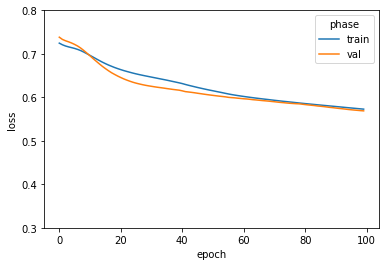

In [111]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.lineplot(data=df_loss, x="epoch", y="loss", hue="phase")
plt.ylim(0.3,0.8)

In [109]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plot
import numpy as np

def draw_graph(classifier, data):
  x_min, x_max = data["x0"].min() - 1, data["x0"].max() + 1
  y_min, y_max = data["x1"].min() - 1, data["x1"].max() + 1
  h = 0.04
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plot.figure(figsize=(8, 6))

  colormap_light = ListedColormap(["yellow", "orange"])
  plot.contourf(xx, yy, Z, colormap=colormap_light)

  colormap_bold = ["pink", "c"]
  sb.scatterplot(
      data=data,
      x="x0", y="x1",hue="label",
      palette=colormap_bold,
      alpha=1.0,
      edgecolor="brown",
  )
  plot.xlim(xx.min(), xx.max())
  plot.ylim(yy.min(), yy.max())

  y_predict = classifier.predict(data[["x0","x1"]].to_numpy())
  hit_count=0
  for i in range(len(df)):
    if y_predict[i] == data['label'].iloc[i]:
      hit_count += 1

  plot.title(
      f"{str(classifier)} classification "
      f"\nacc={hit_count/len(data)*100:.1f} % ({hit_count}/{len(data)})"
  )
  # plot.xlabel(iris.feature_names[0])
  # plot.ylabel(iris.feature_names[1])

## 단계5. 학습결과 확인

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


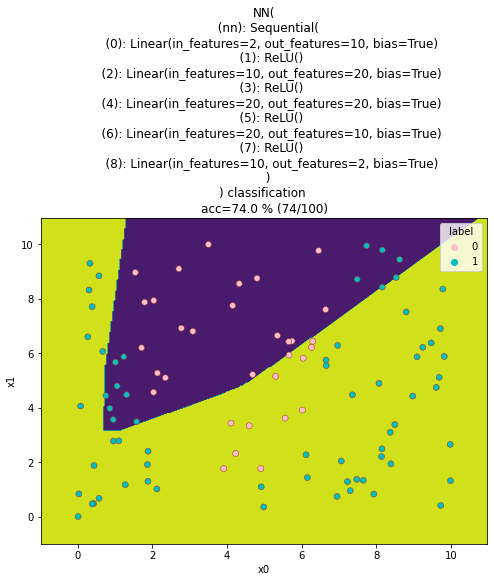

In [112]:
draw_graph(classifier=model, data=df)

## data_size, epoch, 등을 변경해가면서 실험

In [113]:
def nn_experiment(data_size=100, epoch=10, lr=0.0001, func=func1):  

  df = generate(func, data_size, 10)

  print(f"# Generated: {data_size}")
  sb.scatterplot(data=df, x="x0", y="x1", hue="label")
  plt.show()

  print(f"# Prepare model")
  model = NN(2, 2)
  model = model.to(device)
  loss_func = nn.CrossEntropyLoss()   
  optimizer = optim.Adam(model.parameters(), lr = lr)

  print("# Training")
  model, df_loss = train(model, df, epoch, loss_func, optimizer)

  print("# Training summary")
  sb.lineplot(data=df_loss, x="epoch", y="loss", hue="phase")
  plt.ylim(0.3, 0.8)
  plt.show()

  print("# Evaluation")
  df = generate(func, 100, 10)          # 학습때 사용하지 않은 신규 데이터를 생성해서 테스트
  draw_graph(classifier=model, data=df)
  plt.show()

# Generated: 100


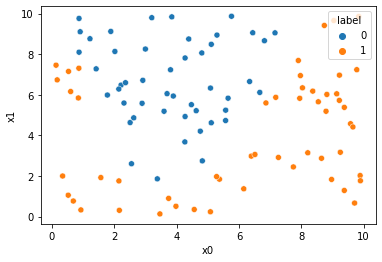

# Prepare model
# Training


train_loss:0.50485, val_loss:0.37107 duration: 0.2s: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]

# Training summary


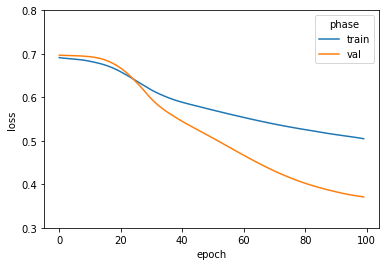

# Evaluation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


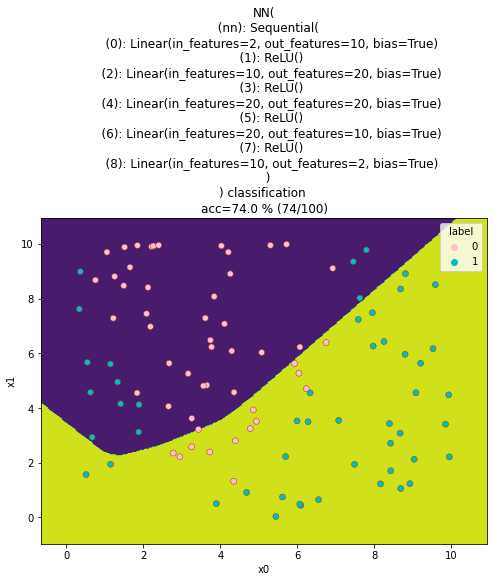

In [114]:
nn_experiment(data_size=100, epoch=100, func=func2)

# Generated: 100


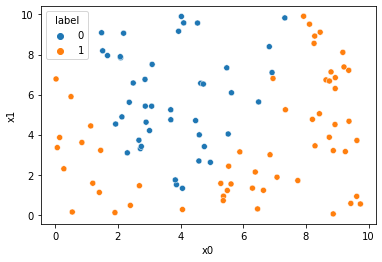

# Prepare model
# Training


train_loss:0.40188, val_loss:0.40866 duration: 0.3s: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


# Training summary


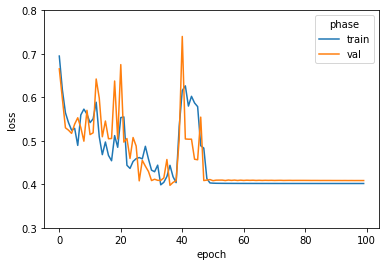

# Evaluation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


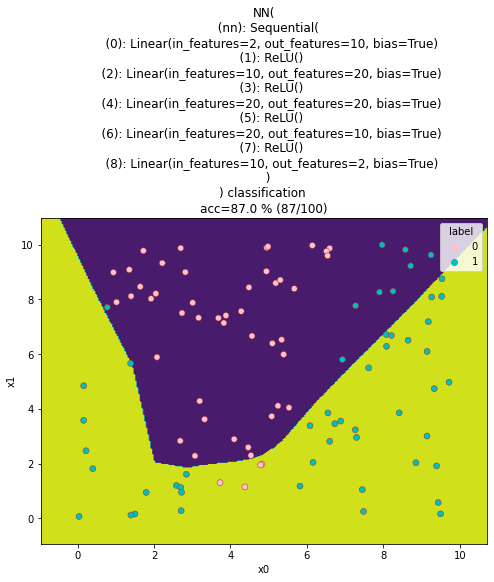

In [120]:
# learning rate를 키웠을때
nn_experiment(data_size=100, epoch=100, func=func2, lr=0.005)

# Generated: 100


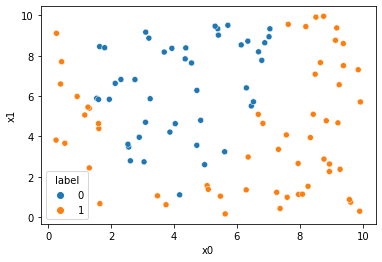

# Prepare model
# Training


train_loss:0.53178, val_loss:0.60487 duration: 0.2s: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


# Training summary


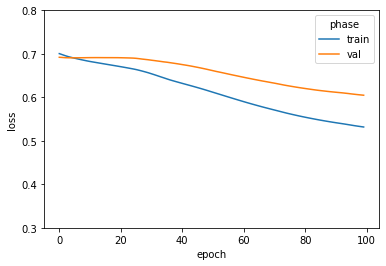

# Evaluation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


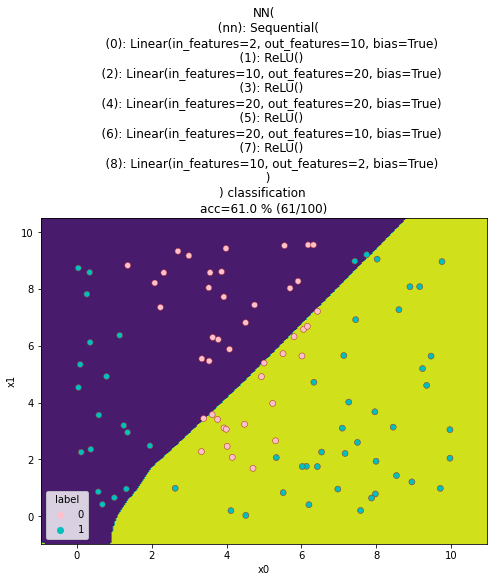

In [121]:
# learning rate를 작게했을때
nn_experiment(data_size=100, epoch=100, func=func2, lr=0.00005)

# Generated: 100


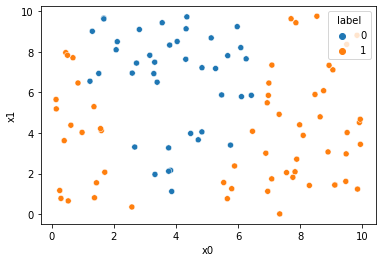

# Prepare model
# Training


train_loss:0.31637, val_loss:0.41714 duration: 0.2s: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


# Training summary


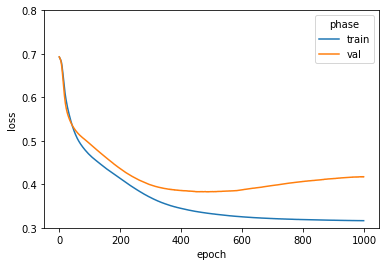

# Evaluation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


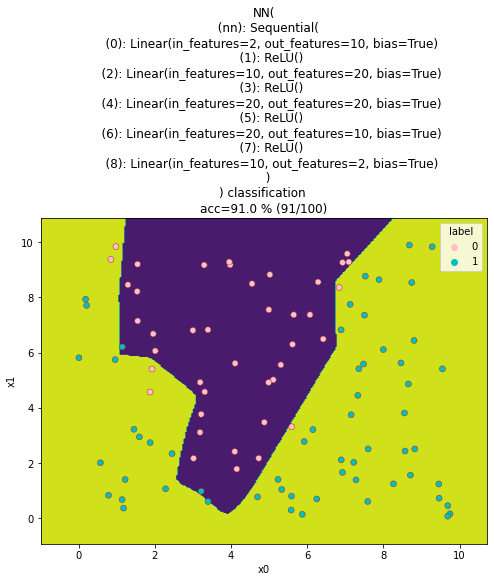

In [122]:
# epoch을 크게 했을때
nn_experiment(data_size=100, epoch=1000, func=func2)

# Generated: 1000


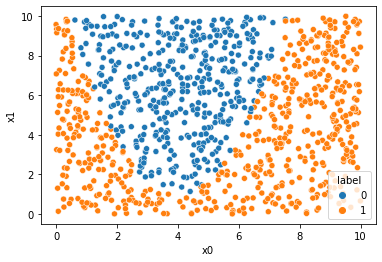

# Prepare model
# Training


train_loss:0.33581, val_loss:0.34164 duration: 1.8s: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]

# Training summary


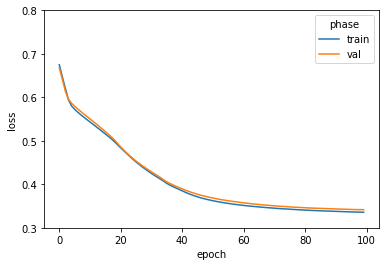

# Evaluation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


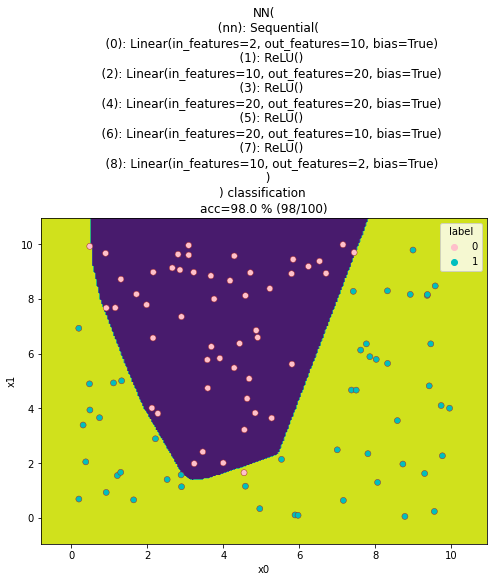

In [116]:
# 데이터 사이즈를 크게 했을때
nn_experiment(data_size=1000, epoch=100, func=func2, lr=0.0001)

# Generated: 100


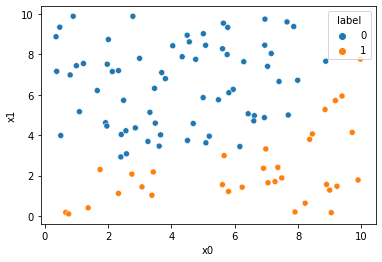

# Prepare model
# Training


train_loss:0.36677, val_loss:0.37292 duration: 0.2s: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]

# Training summary


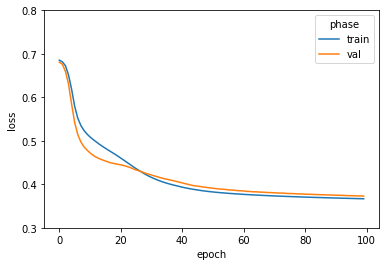

# Evaluation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'colormap'
  from ipykernel import kernelapp as app


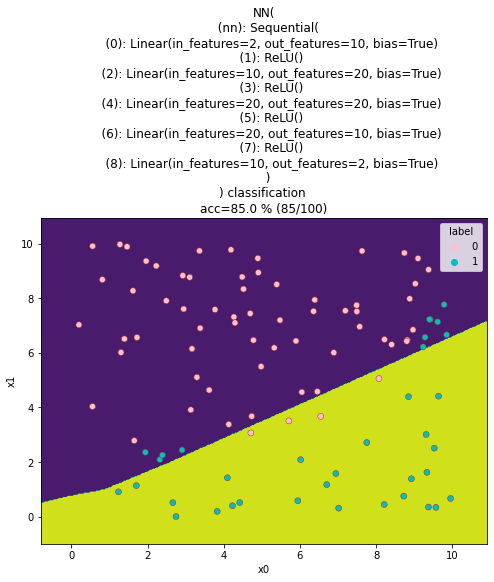

In [119]:
# func1 로 실험
nn_experiment(data_size=100, epoch=100, func=func1)